# Term Deposit Sale

## Goal

Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

## Attribute Information

### Input Variables:

### Bank Client Data

1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account

### Related to previous contact

9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*

### Other attributes

13. campaign: number of contacts performed during this campaign and for this client
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
15. previous: number of contacts performed before this campaign and for this client
16. poutcome: outcome of the previous marketing campaign

### Output variable (desired target):

17. Target: Tell us has the client subscribed a term deposit. (Yes, No)

# Code

In [34]:
# account for/ignore version based warnings

import warnings
warnings.filterwarnings('ignore')

In [35]:
# libraries, modules

import numpy as np
import pandas as pd
import random

# visualization libraries, modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline

In [36]:
# existing data

deposit_data = pd.read_csv('bank-full.csv')

In [37]:
# confirming conversion of the csv file into a Pandas DataFrame

type(deposit_data)

pandas.core.frame.DataFrame

In [38]:
# determine shape of the dataset

deposit_data.shape

(45211, 17)

In [39]:
# First 5 rows of our dataset to get a sense of the dataset

deposit_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [40]:
# to read into the different columns datatype

deposit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [41]:
# to read into the statistics of the dataset columnwise

deposit_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### We would normally consider balance, duration, campaign, pdays and previous to be columns of some significance to the target variable and we observe that each of these columns have outliers

### We shall also take the negative values of balance to be the customer owing the bank credit or money 

In [42]:
# Although clear from the info() function, confirming that there are no Null values

deposit_data.isnull().values.any()

False

In [43]:
# To check for any false input (neither 'yes' nor 'no')

deposit_data['Target'].value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

### We can cearly see that there are no incorrect input in the Target column

In [44]:
# Check for customers subsrcibed to Term Deposit based on historical data

accepted = len(deposit_data.loc[deposit_data['Target'] == 'yes'])
not_accepted = len(deposit_data.loc[deposit_data['Target'] == 'no'])
print("Number of true cases: {0} ({1:2.2f}%)".format(accepted, (accepted / (accepted + not_accepted)) * 100 ))
print("Number of false cases: {0} ({1:2.2f}%)".format(not_accepted, (not_accepted / (accepted + not_accepted)) * 100))

Number of true cases: 5289 (11.70%)
Number of false cases: 39922 (88.30%)


### The data is clearly imbalanced. This is bound to provide a higher precision than recall for our models
### However the success rate for the given bank can be taken to be good given the product

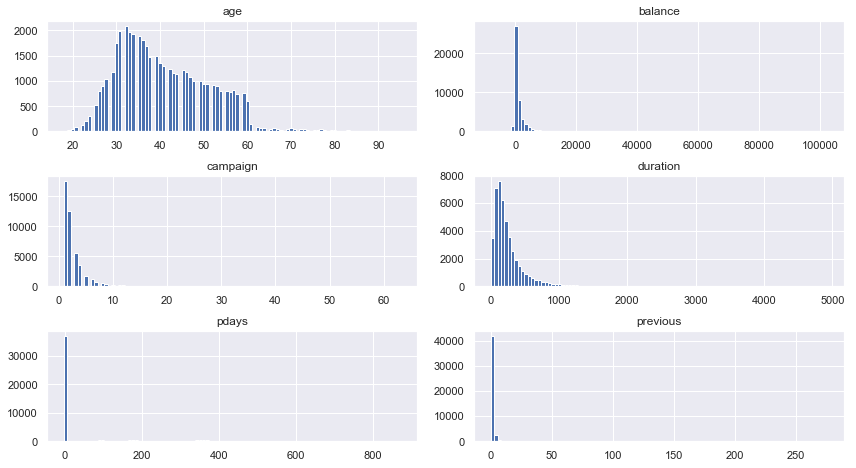

In [45]:
columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
deposit_data[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2)); 

plt.tight_layout()

### Balance, Duration and Campaign have highly skewed distributions while there are not too many values representing the number of previous contacts and the number of days since the last contact

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

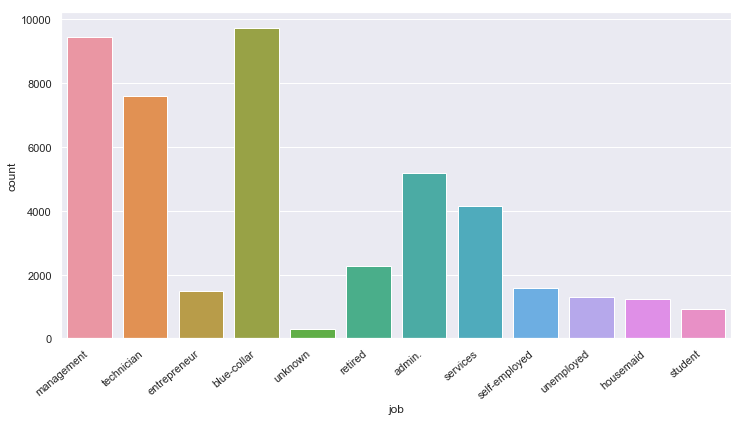

In [46]:
# The countplot for the customer job
# a few variations to the style and labels have been made to make the data more readable


plt.figure(figsize=(12,6))
occ = sns.countplot(deposit_data['job'])
occ.set_xticklabels(occ.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

In [47]:
deposit_data['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

### There are unknown values and these may have to be accounted for later depending on its significance

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

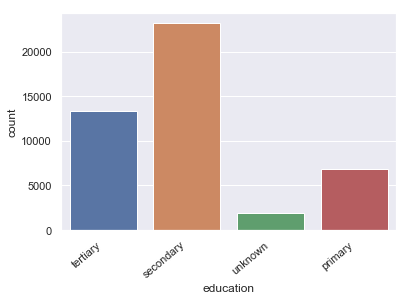

In [48]:
# The countplot for the customer education
# a few variations to the style and labels have been made to make the data more readable

occ = sns.countplot(deposit_data['education'])
occ.set_xticklabels(occ.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

In [49]:
deposit_data['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

### There are a significant number of unknown values here as well and these may have to be accounted for later depending on its significance

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

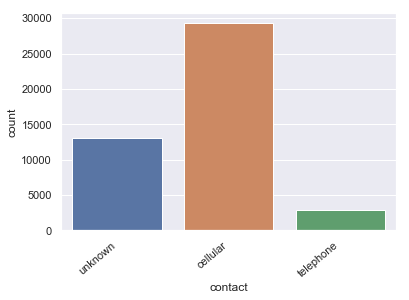

In [50]:
# The countplot for the customer previous contact
# a few variations to the style and labels have been made to make the data more readable

occ = sns.countplot(deposit_data['contact'])
occ.set_xticklabels(occ.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

### The number of unknown values are too high to be replaced and could even represent other modes of contact such as direct door-door contact

In [51]:
deposit_data['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [52]:
deposit_data['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [53]:
deposit_data['default'].value_counts()

no     44396
yes      815
Name: default, dtype: int64

### Almost all the customers have not defaulted and therefore should not have too much correlation to the Target

In [54]:
deposit_data['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [55]:
deposit_data['loan'].value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

### The number of customer who did take a loan is not lot in terms of the total number of customers but it is definitely comparabe to the number of customers who opted for a Term Deposit and therefore may be significant

In [56]:
deposit_data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

### This seems to suggest that of all the customers who had a previous campaign contact, an impressive percentage opted for a Term Deposit (success) and therefore may be a significant attribute

In [57]:
deposit_data['pdays'].nunique()

559

In [58]:
deposit_data[(deposit_data['pdays'] == -1)].count()

age          36954
job          36954
marital      36954
education    36954
default      36954
balance      36954
housing      36954
loan         36954
contact      36954
day          36954
month        36954
duration     36954
campaign     36954
pdays        36954
previous     36954
poutcome     36954
Target       36954
dtype: int64

In [59]:
deposit_data[deposit_data['previous'] == 0].count()

age          36954
job          36954
marital      36954
education    36954
default      36954
balance      36954
housing      36954
loan         36954
contact      36954
day          36954
month        36954
duration     36954
campaign     36954
pdays        36954
previous     36954
poutcome     36954
Target       36954
dtype: int64

### A large percentage of the customers did not have previous contacts

In [60]:
deposit_data[(deposit_data['previous'] == 0) & (deposit_data['poutcome'] != 'unknown')].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

### So as expected, for all cases where there was no previous contact, the outcome is unknown

In [61]:
deposit_data[(deposit_data['previous'] != 0) & (deposit_data['poutcome'] == 'unknown')].count()

age          5
job          5
marital      5
education    5
default      5
balance      5
housing      5
loan         5
contact      5
day          5
month        5
duration     5
campaign     5
pdays        5
previous     5
poutcome     5
Target       5
dtype: int64

### This suggests that there are 5 cases where the outcome from the previous campaign is unknown. Since this number is really small in comparison to the total number of observations, we opt to drop these observations

In [62]:
deposit_data[(deposit_data['previous'] != 0) & (deposit_data['poutcome'] == 'unknown')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
40658,61,retired,married,tertiary,no,3140,yes,yes,cellular,6,aug,975,4,98,1,unknown,yes
41821,39,management,married,tertiary,no,184,no,no,cellular,15,oct,206,1,168,5,unknown,no
42042,26,admin.,single,secondary,no,338,no,no,cellular,29,oct,209,1,188,2,unknown,yes
43978,30,technician,single,secondary,no,254,yes,yes,cellular,24,jun,167,3,416,2,unknown,no
45021,37,management,married,secondary,no,209,no,no,cellular,14,oct,183,3,528,7,unknown,no


In [63]:
deposit_data2 = deposit_data.copy(deep=True)
deposit_data3 = deposit_data.copy(deep=True)
deposit_data2.drop(deposit_data.index[[40658, 41821, 42042, 43978, 45021]], inplace=True)
deposit_data3.drop(deposit_data.index[[40658, 41821, 42042, 43978, 45021]], inplace=True)

In [64]:
deposit_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45206 entries, 0 to 45210
Data columns (total 17 columns):
age          45206 non-null int64
job          45206 non-null object
marital      45206 non-null object
education    45206 non-null object
default      45206 non-null object
balance      45206 non-null int64
housing      45206 non-null object
loan         45206 non-null object
contact      45206 non-null object
day          45206 non-null int64
month        45206 non-null object
duration     45206 non-null int64
campaign     45206 non-null int64
pdays        45206 non-null int64
previous     45206 non-null int64
poutcome     45206 non-null object
Target       45206 non-null object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


In [65]:
deposit_data2[(deposit_data['previous'] != 0) & (deposit_data['poutcome'] == 'unknown')].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [66]:
deposit_data2.reset_index(inplace=True)
deposit_data3.reset_index(inplace=True)

In [67]:
deposit_data2.tail()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
45201,45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45202,45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45203,45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45204,45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45205,45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


## Now that we have an idea of the missing or unknown values as well as the distribution, we can look at accounting for the outliers and the missing values

In [68]:
# job with highest frequency as also observed earlier

deposit_data2['job'].mode()

0    blue-collar
dtype: object

In [69]:
# We observe in our dataset that job takes a small set of unknown values
# Here we impute these values with mode value of job mentioned above

from sklearn.impute import SimpleImputer
rep = SimpleImputer(missing_values= 'unknown', strategy="constant", fill_value='blue-collar')

cols=['job']

imputer1 = rep.fit(deposit_data2[cols])
deposit_data2[cols] = imputer1.transform(deposit_data2[cols])
imputer2 = rep.fit(deposit_data3[cols])
deposit_data3[cols] = imputer2.transform(deposit_data3[cols])

In [70]:
deposit_data2['job'].value_counts()

blue-collar      10020
management        9456
technician        7596
admin.            5170
services          4154
retired           2263
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: job, dtype: int64

### In column 'job', the number of unknown values are significantly small and therefore should not affect the percentage of the job with highest frequency (blue-collar) significantly

In [71]:
deposit_data2['education'].mode()

0    secondary
dtype: object

In [72]:
# We observe in our dataset that education takes a set of unknown values
# Here we impute these values with mode value of education mentioned above

from sklearn.impute import SimpleImputer
rep = SimpleImputer(missing_values= 'unknown', strategy="constant", fill_value='secondary')

cols=['education']

imputer1 = rep.fit(deposit_data2[cols])
deposit_data2[cols] = imputer1.transform(deposit_data2[cols])
imputer2 = rep.fit(deposit_data3[cols])
deposit_data3[cols] = imputer2.transform(deposit_data3[cols])

In [73]:
deposit_data2['education'].value_counts()

secondary    25056
tertiary     13299
primary       6851
Name: education, dtype: int64

### In column 'education'. although the number of unknown values are sufficiently high and could refer to another level of education, including those who are uneducated, it seems unlikely.

### The secondary level has a significantly higher frequency and in an ordered education set, would also be the median value. Therefore we shall assign the unknown values with 'secondary' for now. Necessary changes may be made based on results later. 

In [74]:
deposit_data2['contact'].value_counts()

cellular     29280
unknown      13020
telephone     2906
Name: contact, dtype: int64

### As stated earlier, the number of unknown values are too high to assign to either of the other values and therefore is treated as another categorical value

## Let's now look at some of the previous contact data besides contact

In [75]:
# previous contact 'month' spread

deposit_data2['month'].value_counts()

may    13766
jul     6895
aug     6246
jun     5340
nov     3970
apr     2932
feb     2649
jan     1403
oct      735
sep      579
mar      477
dec      214
Name: month, dtype: int64

### We observe a trend in terms of the more busy months of the campaign

## Lets now try to look at the outliers and possible methods to address them

In [76]:
# previous contact 'duration' spread

deposit_data2['duration'].nunique()

1572

### The quartiles show that there are a lot of outliers greater than Q4

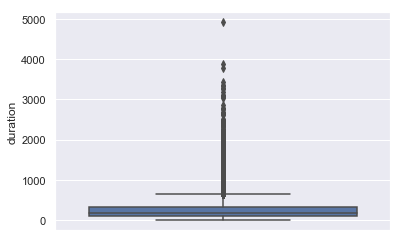

In [77]:
sns.boxplot(y = deposit_data2['duration'])

In [78]:
# for 'duration' IQR = 216
# Hence lets determine the number of rows with 'duration' between 0 and 1000

deposit_data2[(deposit_data2['duration'] < 1000)]['duration'].count()

44143

### This covers almost the entire dataset

In [79]:
deposit_data2['duration'] = np.where(deposit_data2['duration'] > 1000, 1000,deposit_data2['duration'])
deposit_data3['duration'] = np.where(deposit_data3['duration'] > 1000, 1000,deposit_data3['duration'])

In [80]:
deposit_data2[(deposit_data2['duration'] < 1001)]['duration'].count()

45206

In [81]:
deposit_data3[(deposit_data2['duration'] < 1001)]['duration'].count()

45206

### The major outliers in terms of 'duration' have been set to a maximum duration of 1000 to refer to all customers who had a long 'duration' contact

### The data although skewed still has a decent spread

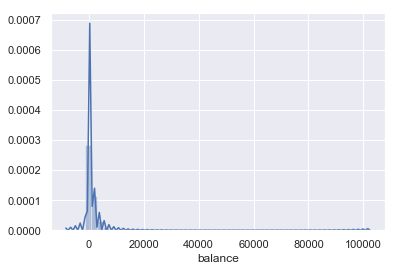

In [82]:
sns.distplot(deposit_data2['balance'])

### The quartiles show that there are outliers less than Q1 and greater than Q4

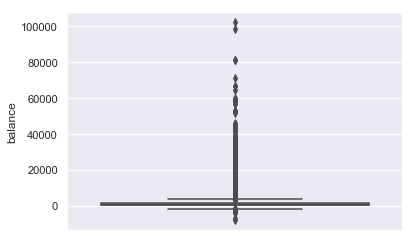

In [83]:
sns.boxplot(y = deposit_data2['balance'])

In [84]:
# for 'balance' IQR = 1356
# Hence lets determine the number of rows with 'balance' between -1000 and 10000

deposit_data2[(deposit_data2['balance'] > -1000) & (deposit_data2['balance'] < 10000)]['balance'].count()

44233

### This covers almost the entire dataset

In [85]:
deposit_data2['balance'] = np.where(deposit_data2['balance'] < -1000, -1000, deposit_data2['balance'])
deposit_data3['balance'] = np.where(deposit_data3['balance'] < -1000, -1000, deposit_data3['balance'])

In [86]:
deposit_data2['balance'] = np.where(deposit_data2['balance'] > 10000, 10000, deposit_data2['balance'])
deposit_data3['balance'] = np.where(deposit_data3['balance'] > 10000, 10000, deposit_data3['balance'])

In [87]:
deposit_data2[(deposit_data2['balance'] > -1001) & (deposit_data2['balance'] < 10001)]['balance'].count()

45206

### Setting all highly negative 'balance' to -1000 and large 'balance' to 10000

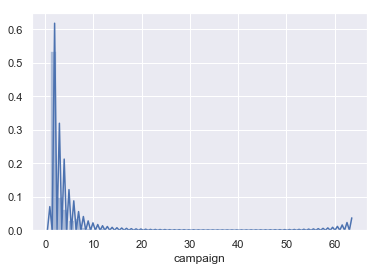

In [88]:
# determining the set values in terms of number of contacts made

sns.distplot(deposit_data2['campaign'])

### The quartiles show that there are a lot of outliers greater than Q4

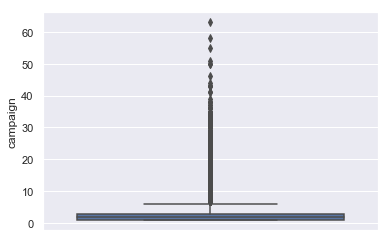

In [89]:
sns.boxplot(y = deposit_data2['campaign'])

In [90]:
deposit_data2[deposit_data2['campaign'] < 9]['campaign'].count()

43417

### This covers almost the entire dataset

In [91]:
deposit_data2['campaign'] = np.where(deposit_data2['campaign'] > 8, 8, deposit_data2['campaign'])
deposit_data3['campaign'] = np.where(deposit_data3['campaign'] > 8, 8, deposit_data3['campaign'])

In [92]:
deposit_data2[deposit_data2['campaign'] < 9]['campaign'].count()

45206

### If 8 or more contacts are made during the campaign, they are set to 8

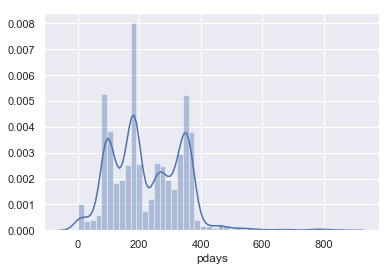

In [93]:
sns.distplot(deposit_data2[deposit_data2['pdays'] > 0]['pdays'])

### This would suggest the possibility of assigning all 'pdays' greater than 450 to 450 

In [94]:
deposit_data2['pdays'] = np.where(deposit_data2['pdays'] > 450, 450, deposit_data2['pdays'])
deposit_data3['pdays'] = np.where(deposit_data3['pdays'] > 450, 450, deposit_data3['pdays'])

In [95]:
deposit_data2[deposit_data2['pdays'] < 451]['pdays'].count()

45206

### This can be used to suggest that the number of days since the last contact from the previous campaign has been a long time ago when 'pdays' is greater than 500

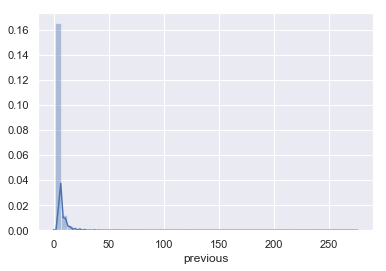

In [96]:
sns.distplot(deposit_data2[deposit_data2['previous'] > 0]['previous'])

In [97]:
# I have checked for customers with mean/median + 2 std deviations (approx 5) contacts previously

deposit_data2[deposit_data2['previous'] < 5]['previous'].count()

43685

In [98]:
deposit_data2['previous'] = np.where(deposit_data2['previous'] > 5, 5, deposit_data2['previous'])
deposit_data3['previous'] = np.where(deposit_data3['previous'] > 5, 5, deposit_data3['previous'])

In [99]:
deposit_data2[deposit_data2['previous'] <= 5]['previous'].count()

45206

### All number of contacts greater than 5 previously have been set to 5 to suggest a large number of contacts previously

## Bivariate Analysis

In [100]:
deposit_data2.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


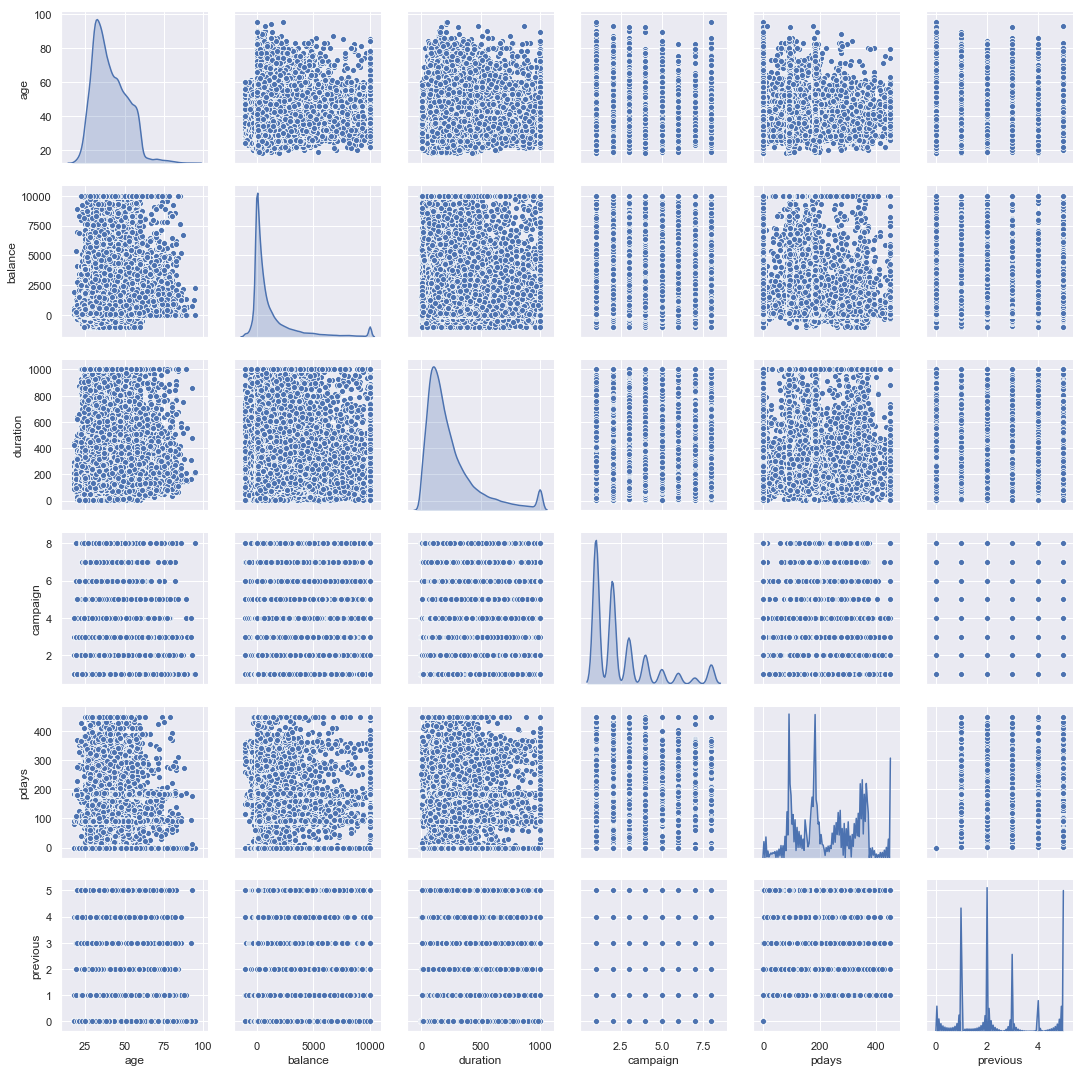

In [101]:
# Lets try to read into any relation betweeen the different columns through a Pair Plot

deposit_data2_attr = deposit_data2.iloc[:, [1,6,12,13,14,15]]
sns.pairplot(deposit_data2_attr, diag_kind='kde')   # to plot density curve instead of histogram on the diag

### There does not seem to be significant correlation between the numerical attributes

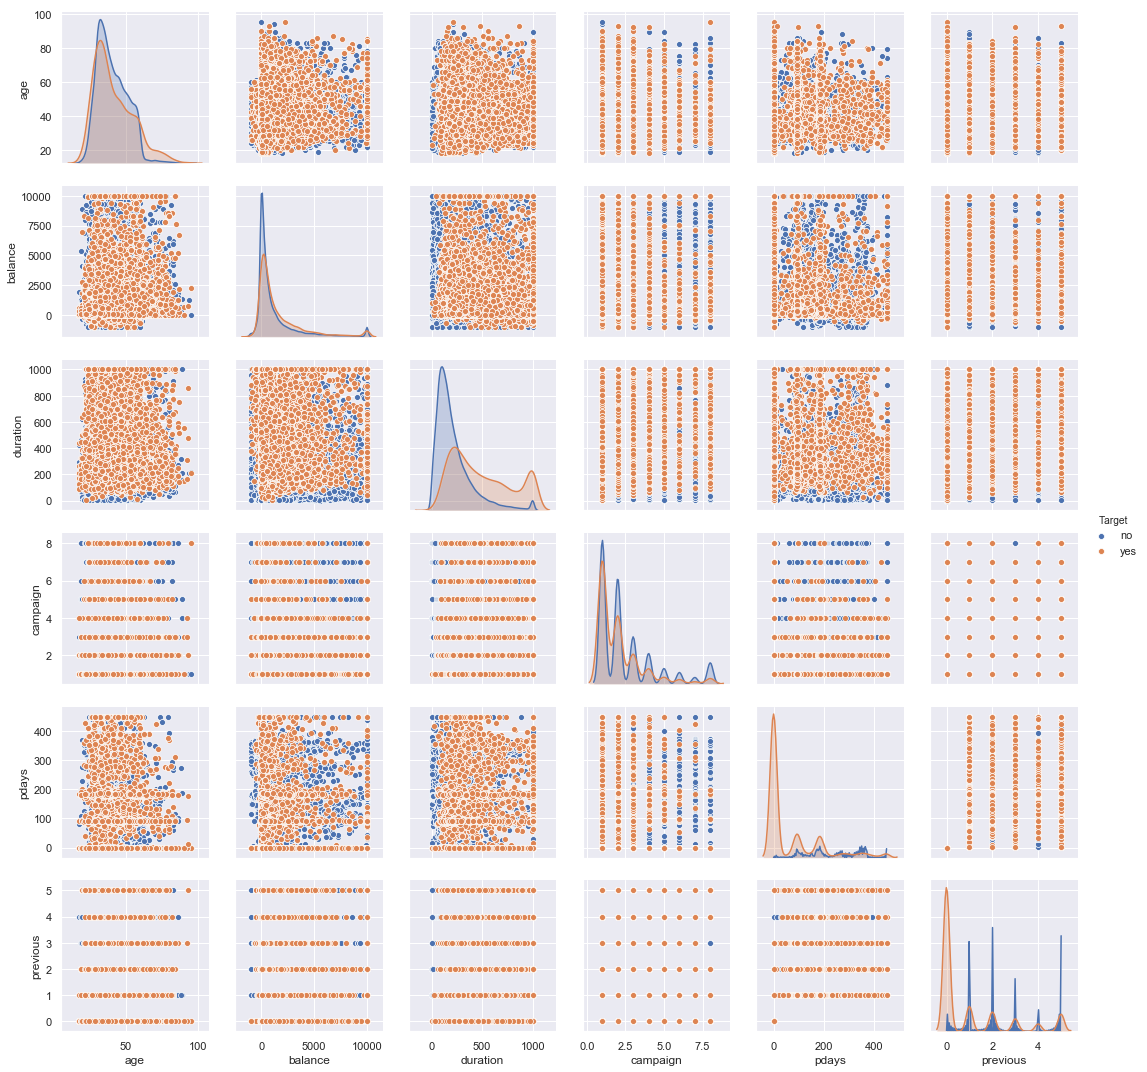

In [102]:
# Lets try to read into any relation betweeen the different columns through a Pair Plot along with the 'Target' as hue

deposit_data2_attr = deposit_data2.iloc[:, [1,6,12,13,14,15,17]]
sns.pairplot(deposit_data2_attr, diag_kind='kde', hue='Target')   # to plot density curve instead of histogram on the diag

### However, we can note that the 'Target' variable gives more successes than failures for low values of 'pdays' and 'previous' when we read into the kde along the diagnol

In [103]:
deposit_data2.corr()

,index,age,balance,day,duration,campaign,pdays,previous
index,1.000000,0.015022,0.094088,-0.061516,0.017754,-0.107007,0.440875,0.427834
age,0.015022,1.000000,0.108701,-0.009002,-0.008329,0.020386,-0.024070,0.007457
balance,0.094088,0.108701,1.000000,0.010525,0.033709,-0.020664,0.009000,0.040434
day,-0.061516,-0.009002,0.010525,1.000000,-0.033989,0.160471,-0.095291,-0.074992
duration,0.017754,-0.008329,0.033709,-0.033989,1.000000,-0.087986,0.003392,0.010286
campaign,-0.107007,0.020386,-0.020664,0.160471,-0.087986,1.000000,-0.093508,-0.067322
pdays,0.440875,-0.024070,0.009000,-0.095291,0.003392,-0.093508,1.000000,0.715750
previous,0.427834,0.007457,0.040434,-0.074992,0.010286,-0.067322,0.715750,1.000000


### Here we also observe a decent postive correlation between pdays and previous but not much between the rest

## Let's read into the relation between the attributes and the Target variable if any

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

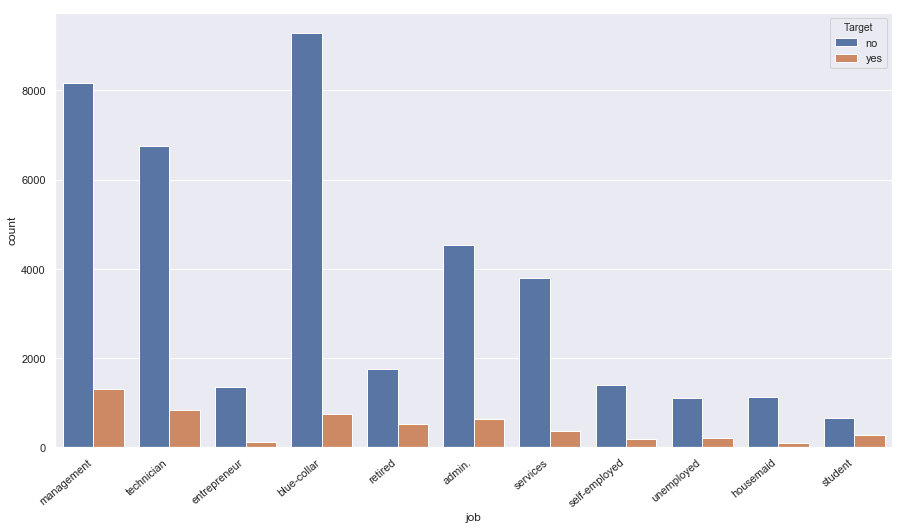

In [104]:
# The countplot for the customer job
# a few variations to the style and labels have been made to make the data more readable


plt.figure(figsize=(15,8))
occ = sns.countplot(deposit_data2['job'], hue = deposit_data2['Target'])
occ.set_xticklabels(occ.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

### Most of the successful Taget customers did the most frequent jobs but for a few exceptions as in the case of retired customers and students. This suggests trends we can read into

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

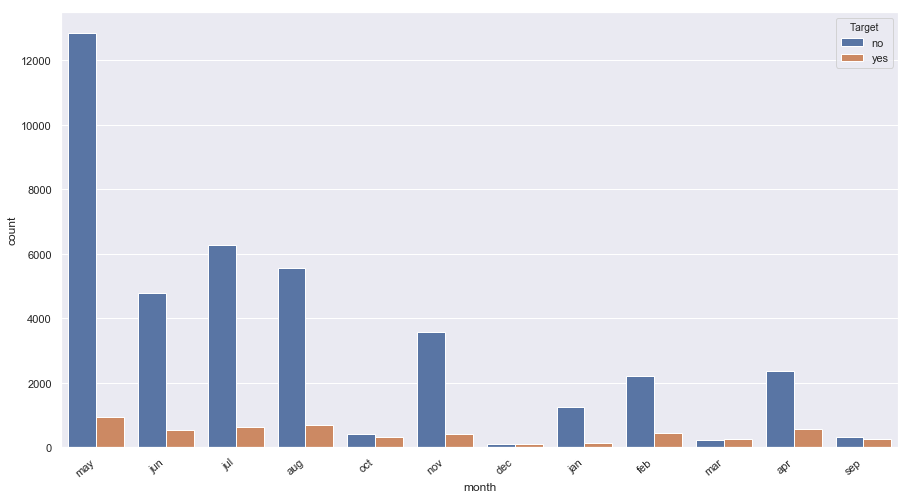

In [105]:
# The countplot for the customer previous contact 'month'
# a few variations to the style and labels have been made to make the data more readable


plt.figure(figsize=(15,8))
occ = sns.countplot(deposit_data2['month'], hue = deposit_data2['Target'])
occ.set_xticklabels(occ.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

### While we can read into a larger number of successful customers in some months, we note that in general campaigns are focussed during these months and therefore are not necessarily entirely reliable. But the data representation does suggest consideration of month

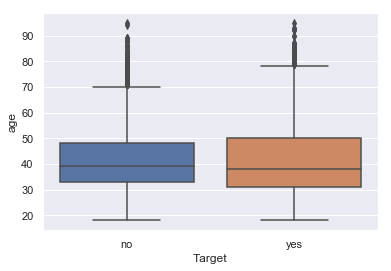

In [106]:
# relation between age and Target

sns.boxplot(y = 'age', x = 'Target', data = deposit_data2)

### We can notice a significant spread of successful Target customers based on age however more than 50% of the customers who declined were between 30 and 50 years old, inclining us towards retired customers again. We notice customers of lower and higher ages have a higher successful representation, giving us something to read into 

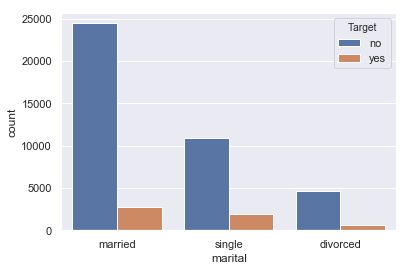

In [107]:
# relation between marital status and Target

sns.countplot('marital', hue = 'Target', data = deposit_data2)

### Here again, while we notice a larger number of successful customers among married and single groups, the percentage of successful contacts among single customers seems to be better

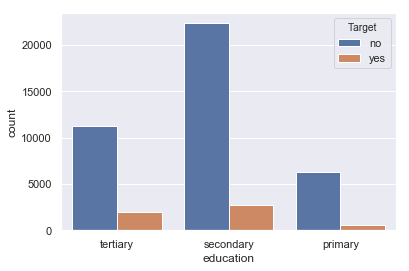

In [108]:
# relation between education and Target

sns.countplot('education', hue = 'Target', data = deposit_data2)

### We observe a better perecentage of success among secondary and tertiary education customers than primary 

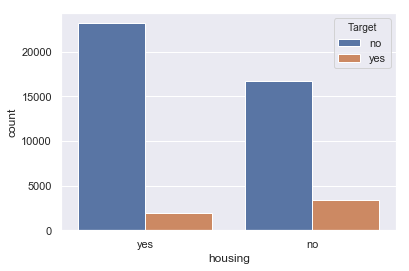

In [109]:
# relation between housing and Target

sns.countplot('housing', hue = 'Target', data = deposit_data2)

### Clearly a higher percentage of customers who have not taken a housing loan have opted for the term deposit

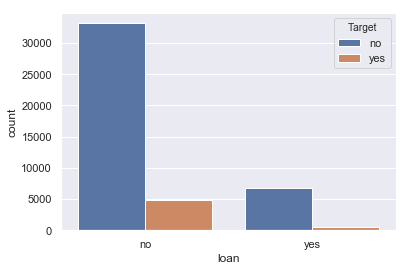

In [110]:
# relation between loan and Target

sns.countplot('loan', hue = 'Target', data = deposit_data2)

### The customers who have not taken a loan seem to be the focus of the campaign and have a decent percentage of success

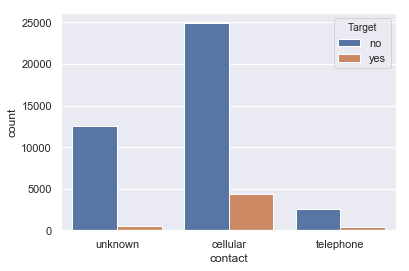

In [111]:
# relation between contact and Target

sns.countplot('contact', hue = 'Target', data = deposit_data2)

### Cellular contact is clearly the preferred mode of contact 

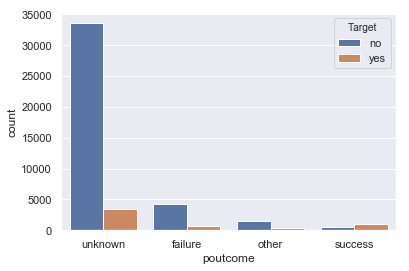

In [112]:
# relation between previous campaign outcome and Target

sns.countplot('poutcome', hue = 'Target', data = deposit_data2)

### Unknown here refers to cases where there were no previous campaigns conducted for the concerned customer. Although, it appears like customers with no previous contact have opted for the term deposit, we should notice that customers who successfully opted for the term deposit in the last campaign were happy to do so again

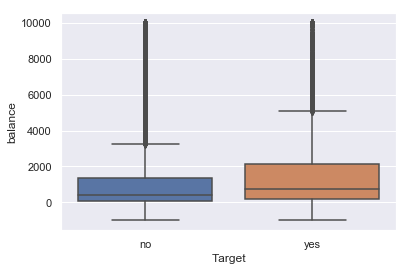

In [113]:
# relation between balance and Target

sns.boxplot(y = 'balance', x = 'Target', data = deposit_data2)

### Customers with a high balance were more likely to opt for the Term Deposit

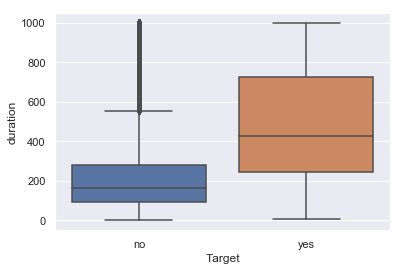

In [114]:
# relation between duration and Target

sns.boxplot(y = 'duration', x = 'Target', data = deposit_data2)

### This seems like one of the most obvious relations. The 'duration' attribute is more likely to succeed as the amount of time engaged with the customer increases

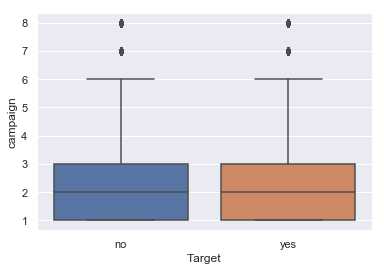

In [115]:
# relation between campaign and Target

sns.boxplot(y = 'campaign', x = 'Target', data = deposit_data2)

### The number of contacts during the present campaign seems to be equally likely to influence the success or failure of the campaign. However, a clear representation of the more likely number of contacts for success can be observed partially

## We should note though that in the case of most categorical attributes, the data among the different categories was not evenly distributed. It was imbalanced.

### Therefore, we will look at all attributes but for 'default' which has highly biased (negative) data values

## Now let's look at converting attributes of type 'object' to 'categorical'

In [116]:
# We label encode the variables with a large number of classes

deposit_data2["job"] = deposit_data2["job"].astype('category').cat.codes
deposit_data2["contact"] = deposit_data2["contact"].astype('category').cat.codes
deposit_data2["month"] = deposit_data2["month"].astype('category').cat.codes

deposit_data3["job"] = deposit_data3["job"].astype('category').cat.codes
deposit_data3["contact"] = deposit_data3["contact"].astype('category').cat.codes
deposit_data3["month"] = deposit_data3["month"].astype('category').cat.codes

In [117]:
# We can observe here the 'job' attribute has been given 11 numerical values

deposit_data2['job'].value_counts()

1     10020
4      9456
9      7596
0      5170
7      4154
5      2263
6      1579
2      1487
10     1303
3      1240
8       938
Name: job, dtype: int64

In [118]:
# Also replacing the categorical var with actual values

deposit_data2['education'] = deposit_data2['education'].replace({1: 'primary', 2: 'secondary', 3: 'tertiary'})
deposit_data2['marital'] = deposit_data2['marital'].replace({1: 'single', 2: 'married', 3: 'divorced'})
deposit_data2['poutcome'] = deposit_data2['poutcome'].replace({1: 'success', 2: 'failure', 3: 'other', 4: 'unknown'})

deposit_data3['education'] = deposit_data3['education'].replace({1: 'primary', 2: 'secondary', 3: 'tertiary'})
deposit_data3['marital'] = deposit_data3['marital'].replace({1: 'single', 2: 'married', 3: 'divorced'})
deposit_data3['poutcome'] = deposit_data3['poutcome'].replace({1: 'success', 2: 'failure', 3: 'other', 4: 'unknown'})

deposit_data2.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,0,58,4,married,tertiary,no,2143,yes,no,2,5,8,261,1,-1,0,unknown,no
1,1,44,9,single,secondary,no,29,yes,no,2,5,8,151,1,-1,0,unknown,no
2,2,33,2,married,secondary,no,2,yes,yes,2,5,8,76,1,-1,0,unknown,no
3,3,47,1,married,secondary,no,1506,yes,no,2,5,8,92,1,-1,0,unknown,no
4,4,33,1,single,secondary,no,1,no,no,2,5,8,198,1,-1,0,unknown,no


In [119]:
# One-Hot encoding

deposit_data2 = pd.get_dummies(deposit_data2, columns=['education', 'marital', 'poutcome'])
deposit_data3 = pd.get_dummies(deposit_data3, columns=['education', 'marital', 'poutcome'])

deposit_data2.head()

,index,age,job,default,balance,housing,loan,contact,day,month,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,4,no,2143,yes,no,2,5,8,...,0,0,1,0,1,0,0,0,0,1
1,1,44,9,no,29,yes,no,2,5,8,...,0,1,0,0,0,1,0,0,0,1
2,2,33,2,no,2,yes,yes,2,5,8,...,0,1,0,0,1,0,0,0,0,1
3,3,47,1,no,1506,yes,no,2,5,8,...,0,1,0,0,1,0,0,0,0,1
4,4,33,1,no,1,no,no,2,5,8,...,0,1,0,0,0,1,0,0,0,1


In [120]:
deposit_data3.head()

,index,age,job,default,balance,housing,loan,contact,day,month,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,4,no,2143,yes,no,2,5,8,...,0,0,1,0,1,0,0,0,0,1
1,1,44,9,no,29,yes,no,2,5,8,...,0,1,0,0,0,1,0,0,0,1
2,2,33,2,no,2,yes,yes,2,5,8,...,0,1,0,0,1,0,0,0,0,1
3,3,47,1,no,1506,yes,no,2,5,8,...,0,1,0,0,1,0,0,0,0,1
4,4,33,1,no,1,no,no,2,5,8,...,0,1,0,0,0,1,0,0,0,1


### We will be dropping the 'deafult' column due to the largely biased data as was noticed above as well as the 'index' and 'day' columns.

In [121]:
# The 'default' column due to reasons stated above is dropped

deposit_data2 = deposit_data2.drop(['index', 'default','day'], axis=1)
deposit_data3 = deposit_data3.drop(['index', 'default','day'], axis=1)

In [122]:
deposit_data2['contact'].value_counts()

0    29280
2    13020
1     2906
Name: contact, dtype: int64

In [123]:
deposit_data2.head()

,age,job,balance,housing,loan,contact,month,duration,campaign,pdays,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,4,2143,yes,no,2,8,261,1,-1,...,0,0,1,0,1,0,0,0,0,1
1,44,9,29,yes,no,2,8,151,1,-1,...,0,1,0,0,0,1,0,0,0,1
2,33,2,2,yes,yes,2,8,76,1,-1,...,0,1,0,0,1,0,0,0,0,1
3,47,1,1506,yes,no,2,8,92,1,-1,...,0,1,0,0,1,0,0,0,0,1
4,33,1,1,no,no,2,8,198,1,-1,...,0,1,0,0,0,1,0,0,0,1


### The Binary classes are assigned 0 or 1

In [124]:
# For Binary column 'housing'

deposit_data2['housing'] = deposit_data2['housing'].map({'yes': 1, 'no': 0})
deposit_data3['housing'] = deposit_data3['housing'].map({'yes': 1, 'no': 0})
deposit_data2.head()

,age,job,balance,housing,loan,contact,month,duration,campaign,pdays,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,4,2143,1,no,2,8,261,1,-1,...,0,0,1,0,1,0,0,0,0,1
1,44,9,29,1,no,2,8,151,1,-1,...,0,1,0,0,0,1,0,0,0,1
2,33,2,2,1,yes,2,8,76,1,-1,...,0,1,0,0,1,0,0,0,0,1
3,47,1,1506,1,no,2,8,92,1,-1,...,0,1,0,0,1,0,0,0,0,1
4,33,1,1,0,no,2,8,198,1,-1,...,0,1,0,0,0,1,0,0,0,1


In [125]:
# For Binary column 'loan' and 'Target'

deposit_data2['loan'] = deposit_data2['loan'].map({'yes': 1, 'no': 0})
deposit_data2['Target'] = deposit_data2['Target'].map({'yes': 1, 'no': 0})
deposit_data3['loan'] = deposit_data3['loan'].map({'yes': 1, 'no': 0})
deposit_data3['Target'] = deposit_data3['Target'].map({'yes': 1, 'no': 0})
deposit_data3.head()

,age,job,balance,housing,loan,contact,month,duration,campaign,pdays,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,4,2143,1,0,2,8,261,1,-1,...,0,0,1,0,1,0,0,0,0,1
1,44,9,29,1,0,2,8,151,1,-1,...,0,1,0,0,0,1,0,0,0,1
2,33,2,2,1,1,2,8,76,1,-1,...,0,1,0,0,1,0,0,0,0,1
3,47,1,1506,1,0,2,8,92,1,-1,...,0,1,0,0,1,0,0,0,0,1
4,33,1,1,0,0,2,8,198,1,-1,...,0,1,0,0,0,1,0,0,0,1


### A look at the correlation between numeric columns

In [126]:
# Lets look at the correlation between the different columns in numerical terms

deposit_data2_rel = deposit_data2.iloc[:, [0,2,7,8,9,10,11]]
deposit_data2_rel.corr()

,age,balance,duration,campaign,pdays,previous,Target
age,1.000000,0.108701,-0.008329,0.020386,-0.024070,0.007457,0.025119
balance,0.108701,1.000000,0.033709,-0.020664,0.009000,0.040434,0.070908
duration,-0.008329,0.033709,1.000000,-0.087986,0.003392,0.010286,0.410863
campaign,0.020386,-0.020664,-0.087986,1.000000,-0.093508,-0.067322,-0.083481
pdays,-0.024070,0.009000,0.003392,-0.093508,1.000000,0.715750,0.102110
previous,0.007457,0.040434,0.010286,-0.067322,0.715750,1.000000,0.155051
Target,0.025119,0.070908,0.410863,-0.083481,0.102110,0.155051,1.000000


### The difference in dataframes deposit_data2 and deposit_data3 lies in that deposit_data3 has its large numeric columns scaled as can be seen below 

In [127]:
# Robust Scaler to scale 'age', 'balance' and 'duration' columns

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler() 
deposit_data3[['age', 'balance', 'duration']] = pd.DataFrame(scaler.fit_transform(deposit_data3[['age','balance','duration']]))

In [128]:
deposit_data3_rel = deposit_data3.iloc[:, [0,2,7,8,9,10,11]]
deposit_data3_rel.corr()

,age,balance,duration,campaign,pdays,previous,Target
age,1.000000,0.108701,-0.008329,0.020386,-0.024070,0.007457,0.025119
balance,0.108701,1.000000,0.033709,-0.020664,0.009000,0.040434,0.070908
duration,-0.008329,0.033709,1.000000,-0.087986,0.003392,0.010286,0.410863
campaign,0.020386,-0.020664,-0.087986,1.000000,-0.093508,-0.067322,-0.083481
pdays,-0.024070,0.009000,0.003392,-0.093508,1.000000,0.715750,0.102110
previous,0.007457,0.040434,0.010286,-0.067322,0.715750,1.000000,0.155051
Target,0.025119,0.070908,0.410863,-0.083481,0.102110,0.155051,1.000000


In [129]:
deposit_data3.head()

,age,job,balance,housing,loan,contact,month,duration,campaign,pdays,...,education_primary,education_secondary,education_tertiary,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.266667,4,1.250000,1,0,2,8,0.375000,1,-1,...,0,0,1,0,1,0,0,0,0,1
1,0.333333,9,-0.308997,1,0,2,8,-0.134259,1,-1,...,0,1,0,0,0,1,0,0,0,1
2,-0.400000,2,-0.328909,1,1,2,8,-0.481481,1,-1,...,0,1,0,0,1,0,0,0,0,1
3,0.533333,1,0.780236,1,0,2,8,-0.407407,1,-1,...,0,1,0,0,1,0,0,0,0,1
4,-0.400000,1,-0.329646,0,0,2,8,0.083333,1,-1,...,0,1,0,0,0,1,0,0,0,1


### We can infer that there is no significant correlation between any attribute and the Target variable

# Different Models

### Note: For all models below, 2 sets of data (X,Y) and (X2,Y2) will be used to evaulate their performance

## Logistic Regression

In [130]:
from sklearn.model_selection import train_test_split

X = deposit_data2.drop(['Target','education_primary','marital_divorced', 'poutcome_other'],axis=1)     # Predictor attribute columns (12 X m)
Y = deposit_data2['Target']   # Predicted class (1=True, 0=False) (1 X m)

X2 = deposit_data3.drop(['Target','education_primary','marital_divorced', 'poutcome_other', 'age', 'balance'],axis=1)     # Predictor attribute columns (12 X m)
Y2 = deposit_data3['Target']   # Predicted class (1=True, 0=False) (1 X m)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=103)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.3, random_state=103)
# 103 - random seed number

x_train.head()

,age,job,balance,housing,loan,contact,month,duration,campaign,pdays,previous,education_secondary,education_tertiary,marital_married,marital_single,poutcome_failure,poutcome_success,poutcome_unknown
17433,43,1,69,0,1,0,5,267,5,-1,0,0,0,0,1,0,0,1
38608,31,3,168,1,0,0,8,266,3,-1,0,0,0,0,0,0,0,1
26592,43,6,5704,1,0,0,9,154,3,106,2,1,0,1,0,1,0,0
31557,24,7,496,1,0,0,0,297,1,323,2,1,0,0,1,1,0,0
40208,35,4,925,0,0,0,6,200,4,-1,0,0,1,1,0,0,0,1


In [131]:
from sklearn import metrics

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

In [132]:
# Running a loop to check different values of 'solver'
# all solver can be used with l2, only 'liblinear' and 'saga' works with both 'l1' and 'l2'

train_score = []
test_score = []

solver = ['newton-cg','lbfgs','liblinear','sag','saga']

for i in solver:
    model1 = LogisticRegression(random_state = 103, penalty='l2', C = 0.75, solver=i)  # changing values of solver
    model1.fit(x_train, y_train) 
    y_predict = model1.predict(x_test)     
    train_score.append(round(model1.score(x_train, y_train),3))
    test_score.append(round(model1.score(x_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

[0.9, 0.89, 0.9, 0.883, 0.884]

[0.903, 0.896, 0.903, 0.89, 0.891]


In [133]:
# Running a loop to check different values of 'solver'
# all solver can be used with l2, only 'liblinear' and 'saga' works with both 'l1' and 'l2'

train_score = []
test_score = []

solver = ['newton-cg','lbfgs','liblinear','sag','saga']

for i in solver:
    model2 = LogisticRegression(random_state = 103, penalty='l2', C = 0.75, solver=i)  # changing values of solver
    model2.fit(x_train2, y_train2) 
    y_predict2 = model2.predict(x_test2)     
    train_score.append(round(model2.score(x_train2, y_train2),3))
    test_score.append(round(model2.score(x_test2, y_test2),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

[0.9, 0.898, 0.9, 0.895, 0.892]

[0.903, 0.903, 0.903, 0.898, 0.897]


### We obseve the best accuracy marginally for 'liblinear' 

In [134]:
train_score=[]
test_score=[]

solver = ['liblinear','saga']   # changing values of solver which works with 'l1'

for i in solver:
    model1 = LogisticRegression(random_state = 103,penalty='l1', C = 0.75,solver=i)  #changed penalty to 'l1'
    model1.fit(x_train, y_train) 
    y_predict = model1.predict(x_test)     
    train_score.append(round(model1.score(x_train, y_train),3))
    test_score.append(round(model1.score(x_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['liblinear', 'saga']

[0.9, 0.884]

[0.903, 0.891]


In [135]:
train_score=[]
test_score=[]

solver = ['liblinear','saga']   # changing values of solver which works with 'l1'

for i in solver:
    model2 = LogisticRegression(random_state = 103,penalty='l1', C = 0.75,solver=i)  #changed penalty to 'l1'
    model2.fit(x_train2, y_train2) 
    y_predict2 = model2.predict(x_test2)     
    train_score.append(round(model2.score(x_train2, y_train2),3))
    test_score.append(round(model2.score(x_test2, y_test2),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['liblinear', 'saga']

[0.9, 0.892]

[0.903, 0.897]


### We observe equally high accuracy with l1 for 'liblinear'

In [136]:
# Running a loop to check different values of 'C'

train_score = []                                 
test_score = []

C = [0.01,0.1,0.25,0.5,0.75,1]

for i in C:
    model1 = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', C=i)  # changing values of C
    model1.fit(x_train, y_train)
    
    y_predict = model1.predict(x_test)
    
    train_score.append(round(model1.score(x_train,y_train),3)) # appending training accuracy in a blank list for every run of the loop
    test_score.append(round(model1.score(x_test, y_test),3))   # appending testing accuracy in a blank list for every run of the loop
    
print(C)
print()
print(train_score)
print()
print(test_score)

[0.01, 0.1, 0.25, 0.5, 0.75, 1]

[0.899, 0.9, 0.9, 0.9, 0.9, 0.9]

[0.902, 0.903, 0.903, 0.903, 0.903, 0.903]


In [137]:
# Running a loop to check different values of 'C'

train_score = []                                 
test_score = []

C = [0.01,0.1,0.25,0.5,0.75,1]

for i in C:
    model2 = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', C=i)  # changing values of C
    model2.fit(x_train2, y_train2)
    
    y_predict2 = model2.predict(x_test2)
    
    train_score.append(round(model2.score(x_train2,y_train2),3)) # appending training accuracy in a blank list for every run of the loop
    test_score.append(round(model2.score(x_test2, y_test2),3))   # appending testing accuracy in a blank list for every run of the loop
    
print(C)
print()
print(train_score)
print()
print(test_score)

[0.01, 0.1, 0.25, 0.5, 0.75, 1]

[0.899, 0.9, 0.9, 0.9, 0.9, 0.9]

[0.902, 0.903, 0.903, 0.903, 0.903, 0.903]


### Since the accuracy doesn't vary significantly, we shall stay with the deafult value of 0.5

In [138]:
model1 = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', class_weight = 'balanced') # changing class weight to balanced

model1.fit(x_train, y_train) 

y_predict = model1.predict(x_test)     

print("Training accuracy",model1.score(x_train,y_train))  
print()
print("Testing accuracy",model1.score(x_test, y_test))

Training accuracy 0.8269814182783466

Testing accuracy 0.8272378705205722


### Adding class weights has dropped the accuracy so we shall not apply it

In [139]:
# Therefore the final model for the default Threshold is:

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve

model1 = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', C=0.5) 
model1.fit(x_train, y_train)

y_predict = model1.predict(x_test)

print("Training accuracy",model1.score(x_train, y_train))  
print()
print("Testing accuracy",model1.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, y_predict))
print()
print("Precision:",precision_score(y_test, y_predict))
print()
print("F1 Score:",f1_score(y_test, y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test, y_predict))

Training accuracy 0.8998230312223486

Testing accuracy 0.902964164577496

Recall: 0.3593854375417502

Precision: 0.6011173184357542

F1 Score: 0.4498327759197325

Roc Auc Score: 0.6648978576022054


In [140]:
# Therefore the final model for the default Threshold is:

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve

model2 = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', C=0.5) 
model2.fit(x_train2, y_train2)

y_predict2 = model2.predict(x_test2)

print("Training accuracy",model2.score(x_train2, y_train2))  
print()
print("Testing accuracy",model2.score(x_test2, y_test2))
print()

print("Recall:",recall_score(y_test2, y_predict2))
print()
print("Precision:",precision_score(y_test2, y_predict2))
print()
print("F1 Score:",f1_score(y_test2, y_predict2))
print()
print("Roc Auc Score:",roc_auc_score(y_test2, y_predict2))

Training accuracy 0.9000442421944128

Testing accuracy 0.9027429582657425

Recall: 0.3587174348697395

Precision: 0.5993303571428571

F1 Score: 0.4488090263267865

Roc Auc Score: 0.664480971889905


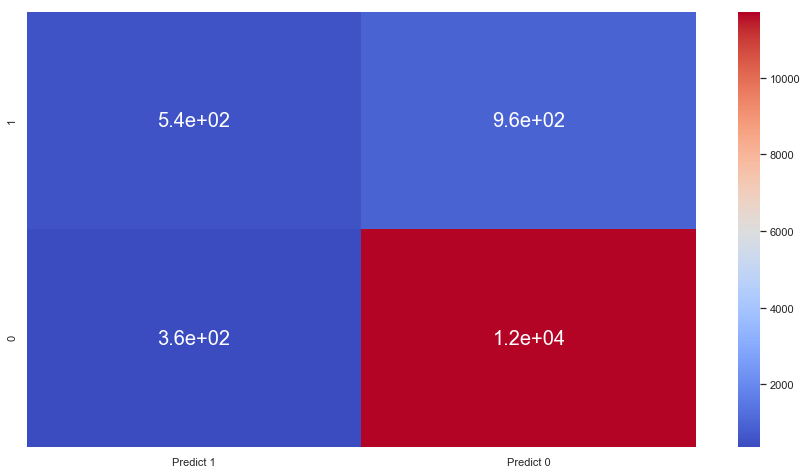

In [141]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### We observed similar results from the metrics with both datasets and have therefore just plotted the confusion matrix for one

### Lets try to read into the model and observe how the precision and recall vary.

Text(0.5, 1.0, 'ROC')

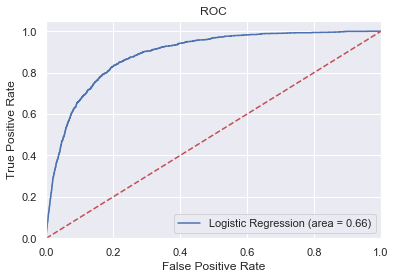

In [142]:
# y_prob is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

y_prob = model1.predict_proba(x_test) 

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

plt.figure()

plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_predict))

plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0, 1])

plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.legend()

plt.title('ROC')

(0, 1)

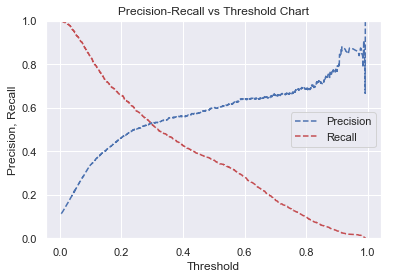

In [143]:
from sklearn.metrics import precision_recall_curve

# retrieve probability of being 1(in second column of y_prob)

precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:,1]) 


pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label= "Precision")
plt.plot(thresholds, recall[: -1], "r--", label= "Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend()
plt.ylim([0,1])

### Some interesting notes:

### 1. Precision and Recall achieve equality at just above 0.5 for a threshold of around 0.3

### 2. With the bank possibly looking at entertaining more Term Deposit campaign successes than failures, recall takes a higher precedence as our metric of interest 

### 3. We are possibly looking at a threshold therefore of between 2 and 3

### Let's look at the model with a lower threshold based on the above plots

In [144]:
model = LogisticRegression(random_state = 103, penalty='l1', solver='liblinear', C=0.5) 
model.fit(x_train, y_train)

threshold = 0.20

y_predict = np.where(model.predict_proba(x_test)[:, 1] > threshold, 1, 0)

print("Training accuracy",model.score(x_train, y_train))  
print()
print("Testing accuracy",model.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, y_predict))
print()
print("Precision:",precision_score(y_test, y_predict))
print()
print("F1 Score:",f1_score(y_test, y_predict))
print()
print("ROC AUC Score:",roc_auc_score(y_test, y_predict))

Training accuracy 0.8998230312223486

Testing accuracy 0.902964164577496

Recall: 0.6566466265865063

Precision: 0.46237064910630293

F1 Score: 0.54264421749931

ROC AUC Score: 0.7809548922406216


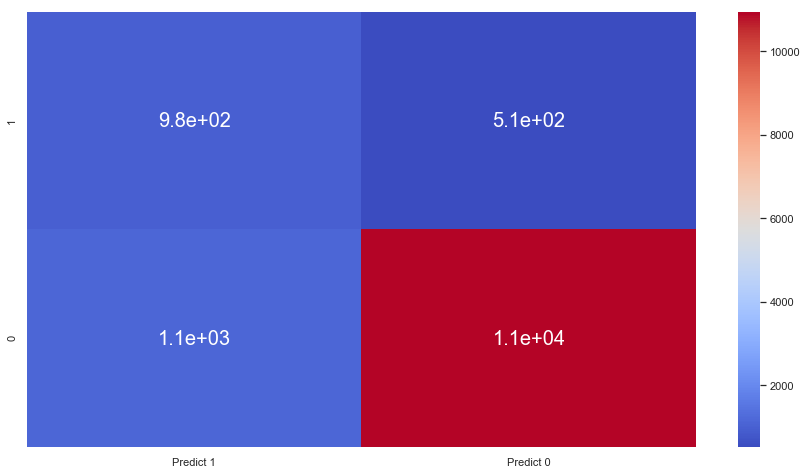

In [145]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Based on the results observed above we can see that they are flexible based on the requirements of the bank and their expectation from the campaigns

## Decision Tree

In [148]:
from sklearn.tree import DecisionTreeClassifier

### We begin with dataset (X,Y)

In [149]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=32)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=32, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [150]:
dt_model.score(x_test, y_test)
test_pred = dt_model.predict(x_test)

In [151]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7002159589243413

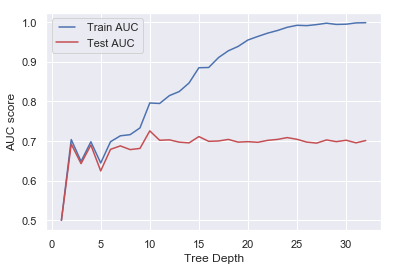

In [152]:
# check for max depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy')
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

In [153]:
print("Training accuracy",dt_model.score(x_train, y_train))  
print()
print("Testing accuracy",dt_model.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 0.9995575780558715

Testing accuracy 0.8762719362925823

Recall: 0.4742818971275885

Precision: 0.443472829481574

F1 Score: 0.4583602324080051

Roc Auc Score: 0.7002159589243413


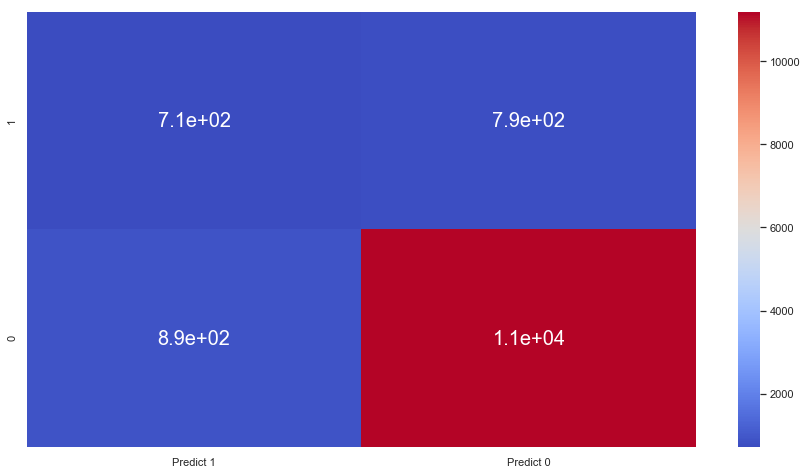

In [154]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Although the ROC score is encouraging, the precision and recall are not great

### We now work with (X2,Y2)

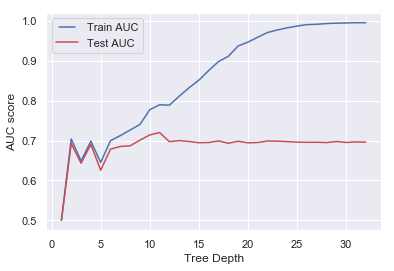

In [155]:
# check for max depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt2 = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy')
   dt2.fit(x_train2, y_train2)
   train_pred2 = dt2.predict(x_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred2 = dt2.predict(x_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

In [156]:
dt_model2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=31)
dt_model2.fit(x_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=31, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [157]:
dt_model2.score(x_test2, y_test2)
test_pred2 = dt_model2.predict(x_test2)

In [158]:
print("Training accuracy",dt_model2.score(x_train2, y_train2))  
print()
print("Testing accuracy",dt_model2.score(x_test2, y_test2))
print()

print("Recall:",recall_score(y_test2, test_pred2))
print()
print("Precision:",precision_score(y_test2, test_pred2))
print()
print("F1 Score:",f1_score(y_test2, test_pred2))
print()
print("Roc Auc Score:",roc_auc_score(y_test2, test_pred2))

Training accuracy 0.9986095310327392

Testing accuracy 0.8722902226810205

Recall: 0.4649298597194389

Precision: 0.42778119237861095

F1 Score: 0.44558258642765686

Roc Auc Score: 0.6938822526943651


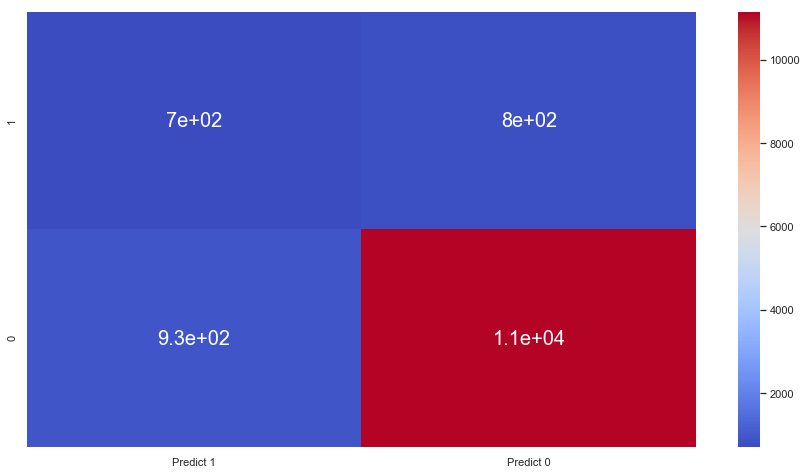

In [159]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test2, test_pred2, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Highly similar results are noted

### Decision Tree with 'gini' criterion

In [160]:
dt_model2 = DecisionTreeClassifier(criterion = 'gini' )
dt_model2.fit(x_train, y_train)
dt_model2.score(x_test, y_test)
test_pred = dt_model2.predict(x_test)

In [161]:
print("Training accuracy",dt_model2.score(x_train, y_train))  
print()
print("Testing accuracy",dt_model2.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 1.0

Testing accuracy 0.8738386668632945

Recall: 0.47695390781563124

Precision: 0.4348355663824604

F1 Score: 0.4549219496654986

Roc Auc Score: 0.7000186033069039


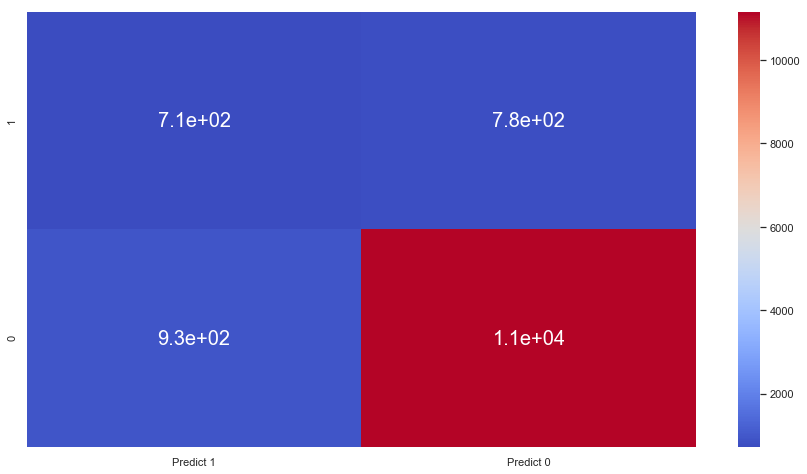

In [162]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Changing the decision tree criterion has not brought about a great difference in results

## Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

### Dataset (X,Y)

In [164]:
rfcl = RandomForestClassifier(n_estimators=300, criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 32, min_samples_leaf=2)
rfcl = rfcl.fit(x_train, y_train)
test_pred = rfcl.predict(x_test)
rfcl.score(x_test , y_test)

0.9059135820675417

In [218]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6859034272440446

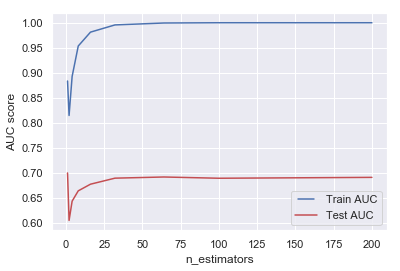

In [165]:
# check for ideal n_estimators

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

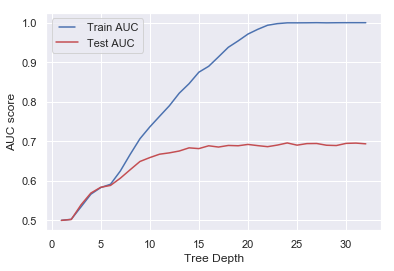

In [166]:
# check for max_depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

In [167]:
rfcl = RandomForestClassifier(n_estimators=100, criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 32, min_samples_leaf=2)
rfcl = rfcl.fit(x_train, y_train)
test_pred = rfcl.predict(x_test)
rfcl.score(x_test , y_test)

0.9079044388733225

In [168]:
print("Training accuracy",rfcl.score(x_train, y_train))  
print()
print("Testing accuracy",rfcl.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 0.978574137277209

Testing accuracy 0.9079044388733225

Recall: 0.40480961923847697

Precision: 0.6286307053941909

F1 Score: 0.4924827305973182

Roc Auc Score: 0.6875685062624213


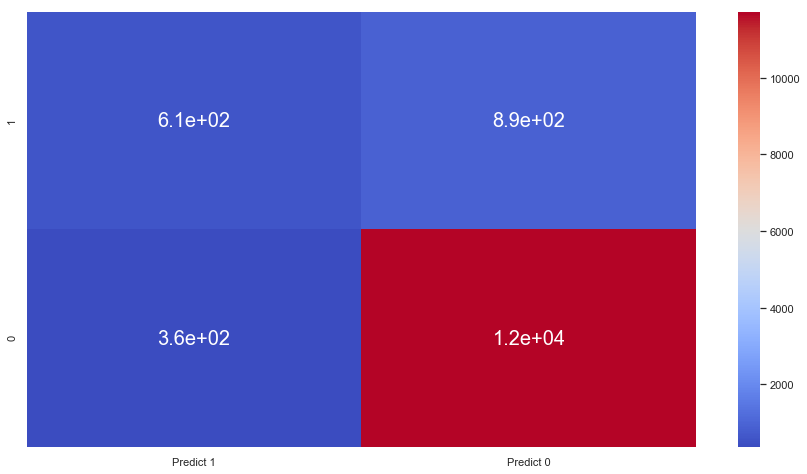

In [169]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Although the ROC score is still almost identical, we observe a rise in Precision at the cost of a small drop in recall 

### Dataset (X2,Y2)

In [170]:
from sklearn.ensemble import RandomForestClassifier
rfcl2 = RandomForestClassifier(criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 5, min_samples_leaf=5)
rfcl2 = rfcl2.fit(x_train2, y_train2)
test_pred2 = rfcl2.predict(x_test2)
rfcl2.score(x_test2 , y_test2)

0.9021530747677333

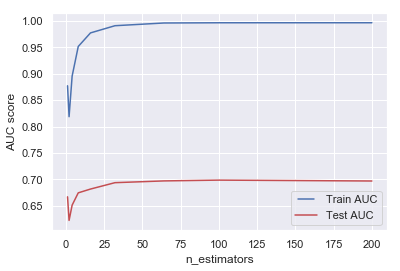

In [171]:
# check for ideal n_estimators

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train2, y_train2)
   train_pred2 = rf.predict(x_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred2 = rf.predict(x_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

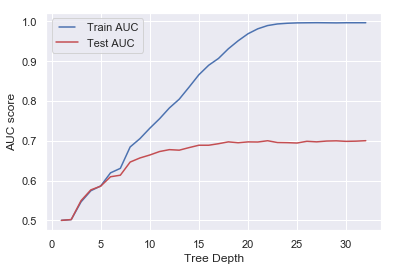

In [172]:
# check for max_depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train2, y_train2)
   train_pred2 = rf.predict(x_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred2 = rf.predict(x_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred2)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

In [173]:
from sklearn.ensemble import RandomForestClassifier
rfcl2 = RandomForestClassifier(n_estimators= 200, criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 30, min_samples_leaf=2)
rfcl2 = rfcl2.fit(x_train2, y_train2)
test_pred2 = rfcl2.predict(x_test2)
rfcl2.score(x_test2 , y_test2)

0.9063559946910485

In [174]:
print("Training accuracy",rfcl2.score(x_train2, y_train2))  
print()
print("Testing accuracy",rfcl2.score(x_test2, y_test2))
print()

print("Recall:",recall_score(y_test2, test_pred2))
print()
print("Precision:",precision_score(y_test2, test_pred2))
print()
print("F1 Score:",f1_score(y_test2, test_pred2))
print()
print("Roc Auc Score:",roc_auc_score(y_test2, test_pred2))

Training accuracy 0.9646694476046012

Testing accuracy 0.9063559946910485

Recall: 0.42084168336673344

Precision: 0.6098741529525653

F1 Score: 0.4980237154150197

Roc Auc Score: 0.6937196398599104


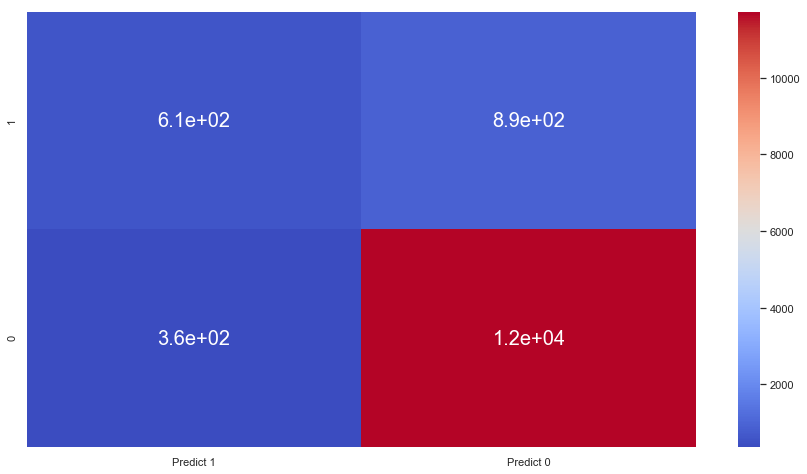

In [175]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### The results are almost identical

# Ensemble Technique -  Boosting

## AdaBoost

In [214]:
from sklearn.ensemble import AdaBoostClassifier
#abcl = AdaBoostClassifier(base_estimator=dt_model, n_estimators=50)
abcl = AdaBoostClassifier( n_estimators= 1000)
abcl = abcl.fit(x_train, y_train)

test_pred = abcl.predict(x_test)
abcl.score(x_test , y_test)

0.9047338150715234

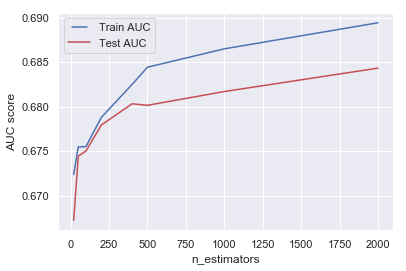

In [215]:
n_estimators = [20, 50, 100, 200, 400, 500, 1000, 2000]
train_results = []
test_results = []

for estimator in n_estimators:
   abc = AdaBoostClassifier(n_estimators=estimator)
   abc.fit(x_train, y_train)
   train_pred = abc.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = abc.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [234]:
abc1 = AdaBoostClassifier( n_estimators= 750, learning_rate=1)
abc1 = abc1.fit(x_train, y_train)

test_pred = abc1.predict(x_test)
abcl.score(x_test , y_test)

0.9047338150715234

In [235]:
print("Training accuracy",abc1.score(x_train, y_train))  
print()
print("Testing accuracy",abc1.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 0.9025723675894325

Testing accuracy 0.9051024922577791

Recall: 0.3981295925183701

Precision: 0.6069246435845214

F1 Score: 0.4808390480032272

Roc Auc Score: 0.6830681116342369


### In the case of the AdaBoost Classifier, the model improves with an increase in the number of estimators but at the cost of time. Therefore, 750 has been picked for n_estimators as the model score does not increase at a significant rate. The learning rate for this was found to be suitable at a rate of 1

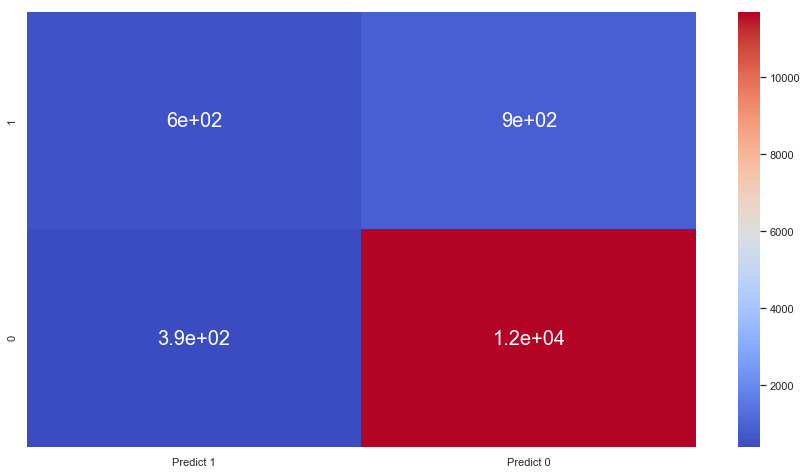

In [236]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### The False Negatives are still of a significant number which affects our metric of precedence - Recall 

## Gradient Boosting

In [243]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05)
gbcl = gbcl.fit(x_train, y_train)
test_pred = gbcl.predict(x_test)
gbcl.score(x_test , y_test)

0.903996460699012

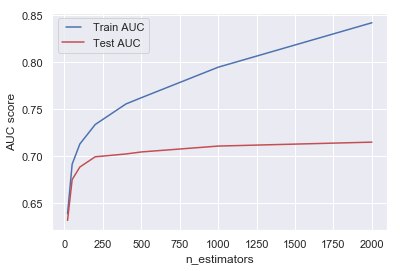

In [244]:
n_estimators = [20, 50, 100, 200, 400, 500, 1000, 2000]
train_results = []
test_results = []

for estimator in n_estimators:
   gbc = GradientBoostingClassifier(n_estimators=estimator)
   gbc.fit(x_train, y_train)
   train_pred = gbc.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = gbc.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [267]:
gbc1 = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.2)
gbc1 = gbc1.fit(x_train, y_train)
test_pred = gbc1.predict(x_test)
gbc1.score(x_test , y_test)

0.9069458781890577

In [268]:
print("Training accuracy",gbc1.score(x_train, y_train))  
print()
print("Testing accuracy",gbc1.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 0.9363860447478195

Testing accuracy 0.9069458781890577

Recall: 0.45958583834335337

Precision: 0.6029798422436459

F1 Score: 0.5216072782410918

Roc Auc Score: 0.7110196079408436


### We have followed the same procedure as for AdaBoost classifier and in this case n_estimators = 500 and learning_rate = 0.2 seemed to provide satisfactory results although at the cost of extended time to run the model

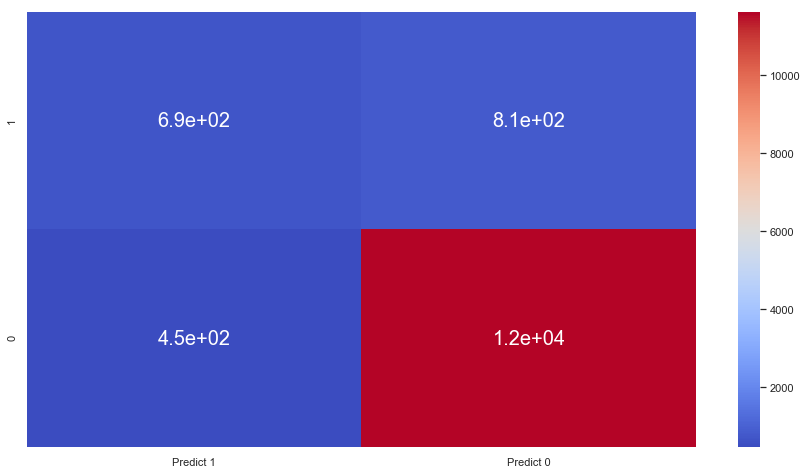

In [271]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### Reduced number of False negatives and more imporatantly an increased number of True Positives

## Ensemble Technique - Bagging

In [272]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=10, max_samples= .7, bootstrap=True)
bgcl = bgcl.fit(x_train, y_train)
test_pred = bgcl.predict(x_test)
bgcl.score(x_test , y_test)

0.9004571597109571

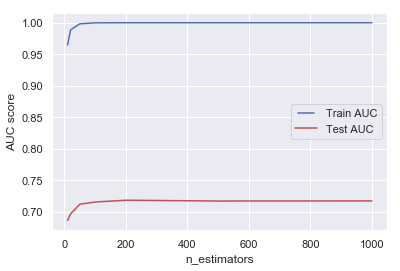

In [273]:
n_estimators = [10, 20, 50, 100, 200, 500, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
   bgc = BaggingClassifier(n_estimators=estimator)
   bgc.fit(x_train, y_train)
   train_pred = bgc.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = bgc.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [296]:
bgc1 = BaggingClassifier(n_estimators=100, max_samples= 0.7, bootstrap=True)
bgc1 = bgc1.fit(x_train, y_train)
test_pred = bgc1.predict(x_test)
bgc1.score(x_test , y_test)

0.9067246718773042

In [297]:
print("Training accuracy",bgc1.score(x_train, y_train))  
print()
print("Testing accuracy",bgc1.score(x_test, y_test))
print()

print("Recall:",recall_score(y_test, test_pred))
print()
print("Precision:",precision_score(y_test, test_pred))
print()
print("F1 Score:",f1_score(y_test, test_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, test_pred))

Training accuracy 0.9950069523448363

Testing accuracy 0.9067246718773042

Recall: 0.46626586506346024

Precision: 0.5996563573883161

F1 Score: 0.5246148064637354

Roc Auc Score: 0.7138208728549792


### Following up on the same procedure as for the Boosting algorithms and the graph plotted

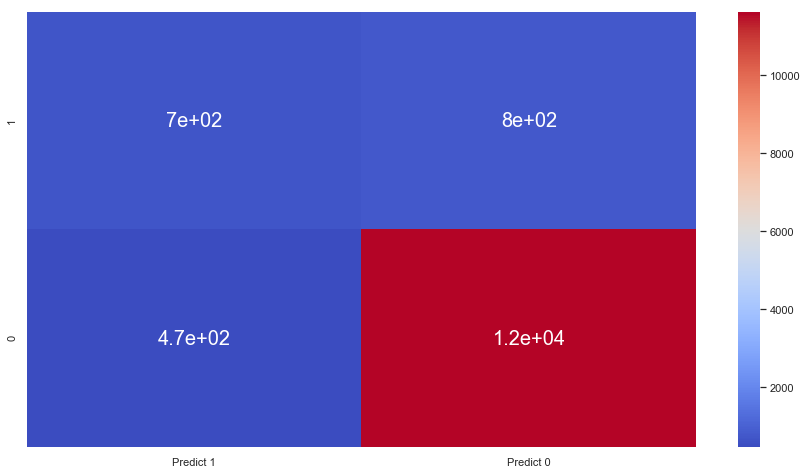

In [299]:
# Let's build a confusion matrix and visualise the same to read deeper into our model

cm = metrics.confusion_matrix(y_test, test_pred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 20})

### A further drop in the False Negatives and therefore improved recall

## Final Insight

### Lets begin by building the dataframe with the best metrics results from each model

In [298]:
model_score = pd.DataFrame([[0.6566, 0.4623, 0.5426, 0.7810],
                            [0.4742, 0.4434, 0.4583, 0.7002],
                            [0.4208, 0.6099, 0.4980, 0.6937],
                            [0.3981, 0.6069, 0.4808, 0.6803],
                            [0.4595, 0.6029, 0.5216, 0.7110],
                            [0.4664, 0.5997, 0.5246, 0.7138]], 
                           index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Adaboost', 'Gradient Boosting', 'Bagging'],
                           columns= ['Recall', 'Precision', 'F1-Score', 'ROC AUC Score'])

### Lets try to visualise the same

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

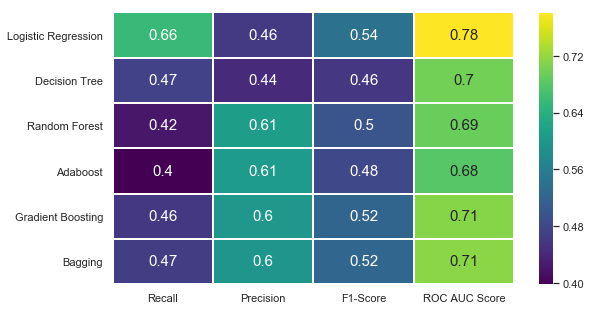

In [300]:
plt.figure(figsize=(9,5))
sns.heatmap(model_score, cmap='viridis', annot=True, annot_kws={"size":15}, linecolor='white', linewidths=1)
plt.tight_layout

### The values and plot above actually give for an interesting read

### It appears obvious that the best model overall and particularly in terms of ROC AUC score is the Logistic Regression model. 

### However, those results were made on the following assumptions:

### 1. Recall is our metric of higher precidence

### 2. The threshold can be flexible depending on the requirements of the bank

### If we were to be asked for results based on a threshold of 0.5, the Logistic Regression results drop

### All other models seem to be providing a similar score

### However, Gradient Descent Boosting and Bagging algorithms seem to provide good results for a large number of estimators and this can be inefficient particularly with time constraints

### We note in fact that the Decision Tree and Random Forest models give us decent results overall

### If so, Decision Tree or Random Forest?

### The Data did not seem to have some really influencial attributes in deciding the Target class

### All attributes, in fact, had really little direct correlation with the 'Target' class 

### Therefore, a Random Forest which does not prioratise some features, unlike a Decision Tree, could be a better solution. If, however, the attributes are reduced or there is a time constraint, a Decision Tree might be preferred

# Finally, if flexible with the campaign requirements and expenses (threshold), the Logistic Regression model is the obvious choice. If not, based on the situation, as described above, another suitable model may be considered